In [1]:
from SimPEG import Mesh, Utils, EM, Maps
from pymatsolver import Pardiso
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pyMKL import mkl_set_num_threads
from multiprocessing import Pool
from SimPEG import Mesh
import pandas as pd

In [2]:
mesh_3d, models = Mesh.TensorMesh.read_vtk("./data/models.vtr")

In [3]:
active_inds = models['actv'].astype(bool)
resistivity = models['resistivity']
resistivity[~active_inds] = np.nan

In [4]:
n = resistivity[active_inds.astype(bool)].size

In [5]:
mesh_2d = Mesh.TensorMesh([mesh_3d.hx, mesh_3d.hy], x0=mesh_3d.x0[:2])

In [6]:
unit_conversion = 1e-12

i_start_hm = 10
i_start_lm = 10

waveform_hm_312 = np.loadtxt("./data/waveform_hm_312.txt")
waveform_lm_312 = np.loadtxt("./data/waveform_lm_312.txt")
time_input_currents_hm_312 = waveform_hm_312[:,0] 
input_currents_hm_312 = waveform_hm_312[:,1]
time_input_currents_lm_312 = waveform_lm_312[:,0] 
input_currents_lm_312 = waveform_lm_312[:,1]

time_gates = np.loadtxt("./data/time_gates")
GateTimeShift=-2.09E-06
MeaTimeDelay=0.000E+00
NoGates=28
t0_lm_312 = waveform_lm_312[:,0].max()
times_lm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_lm:] - t0_lm_312

GateTimeShift=-1.5E-06
MeaTimeDelay=3.500E-04
NoGates=37
t0_hm_312 = waveform_hm_312[:,0].max()
times_hm_312 = (time_gates[:NoGates,0] + GateTimeShift + MeaTimeDelay)[i_start_hm:] - t0_hm_312    

In [7]:
df_skytem = pd.read_csv("./data/slo-skytem-312-data.csv")
hm_header = ['HM_{0}'.format(ii+1) for ii in range(times_hm_312.size)]
lm_header = ['LM_{0}'.format(ii+1) for ii in range(times_lm_312.size)]
line= df_skytem.Line.values
data_hm = df_skytem[hm_header].values
data_lm = df_skytem[lm_header].values

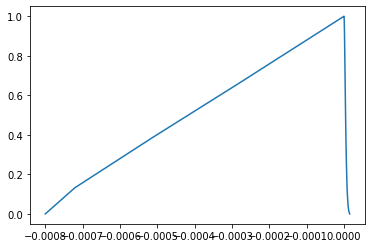

In [8]:
plt.plot(time_input_currents_lm_312, input_currents_lm_312)

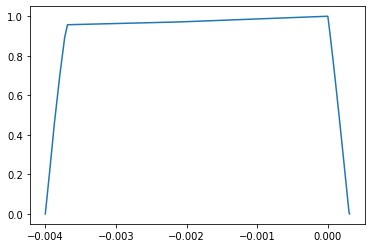

In [9]:
plt.plot(time_input_currents_hm_312, input_currents_hm_312)

In [10]:
from SimPEG import (
    Regularization, Directives, Inversion, 
    InvProblem, Optimization, DataMisfit, Utils, Maps
)
from simpegEM1D import (
    GlobalEM1DProblemTD, GlobalEM1DSurveyTD, 
    get_vertical_discretization_time, EM1DSurveyTD,
    get_2d_mesh, LateralConstraint, 
)
from pymatsolver import PardisoSolver

In [11]:
hz = np.array([ 2.999232 ,  3.1991808,  3.3991296,  3.6990528,  3.8990016,
        4.1989248,  4.498848 ,  4.7987712,  5.0986944,  5.498592 ,
        5.8984896,  6.2983872,  6.6982848,  7.1981568,  7.6980288,
        8.1979008,  8.7977472,  9.3975936, 10.0974144, 10.7972352,
       11.497056 , 12.2968512, 13.1966208, 14.0963904, 14.99616  ,
       16.0958784, 17.1955968, 18.3952896, 19.6949568, 21.0945984,
       22.49424  , 24.0938304, 25.7933952, 27.49296  , 29.492448 ,
       31.491936 , 33.6913728, 35.990784 , 38.490144 ])

In [12]:
n_sounding = df_skytem.shape[0]
mesh = get_2d_mesh(n_sounding, hz)
dem = df_skytem.Elevation.values[:]
height = df_skytem['Src Height'].values[:]
xy = df_skytem[['X', 'Y']].values
rx_locations = np.c_[xy[:,:], height+dem+2.]
src_locations = np.c_[xy[:,:], height+dem]
topo = np.c_[xy[:,:], dem]

time = []
time_dual_moment = []
input_currents = []
time_input_currents = []
input_currents_dual_moment = []
time_input_currents_dual_moment = []

for i_sounding in range(n_sounding):
    time.append(times_hm_312)
    time_dual_moment.append(times_lm_312)
    time_input_currents.append(time_input_currents_hm_312)
    input_currents.append(input_currents_hm_312)
    time_input_currents_dual_moment.append(time_input_currents_lm_312)
    input_currents_dual_moment.append(input_currents_lm_312)        

In [13]:
mapping = Maps.ExpMap(mesh)

survey = GlobalEM1DSurveyTD(
    rx_locations = rx_locations,
    src_locations = src_locations,    
    topo = topo,
    time = time,
    time_dual_moment = time_dual_moment,
    src_type = np.array(["VMD"], dtype=str).repeat(n_sounding),
    rx_type = np.array(["dBzdt"], dtype=str).repeat(n_sounding),    
    offset = np.array([13.25], dtype=float).repeat(n_sounding).reshape([-1,1]),    
    wave_type = np.array(["general"], dtype=str).repeat(n_sounding),    
    field_type = np.array(["secondary"], dtype=str).repeat(n_sounding),    
    input_currents=input_currents,
    time_input_currents=time_input_currents,
    base_frequency = np.array([30.]).repeat(n_sounding),
    input_currents_dual_moment=input_currents_dual_moment,
    time_input_currents_dual_moment=time_input_currents_dual_moment,
    base_frequency_dual_moment = np.array([210.]).repeat(n_sounding),
    moment_type=np.array(["dual"], dtype=str).repeat(n_sounding)
)

prob = GlobalEM1DProblemTD(
    [], sigmaMap=mapping, hz=hz, parallel=True, n_cpu=10,
    Solver=PardisoSolver
)
prob.pair(survey)

>> Set parameters
>> Use multiprocessing for parallelization
>> n_cpu: 10


In [14]:
dobs = -np.hstack((data_hm, data_lm)).flatten()

In [15]:
time = np.r_[times_hm_312, times_lm_312]

In [16]:
DOBS = dobs.reshape((n_sounding, times_hm_312.size+times_lm_312.size))

In [17]:
area = 342.

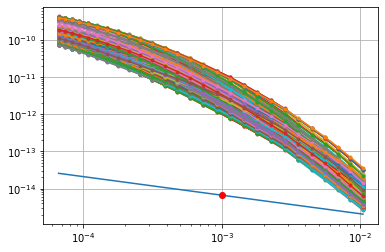

In [18]:
n_turns = 12
tx_currents = 110.10
t = 1e-3
v = 3e-9 / (area * n_turns * tx_currents)
c = v/(t**-0.5)
noise_hm = times_hm_312**-0.5 * c
plt.loglog(times_hm_312, times_hm_312**-0.5 * c)
out = plt.loglog(times_hm_312, -DOBS[::10,:times_hm_312.size].T, '.-')
# plt.plot(times_hm_312, np.ones_like(times_hm_312) * 1e-14, 'k--')
plt.plot(t, v, 'ro')
plt.grid(True)

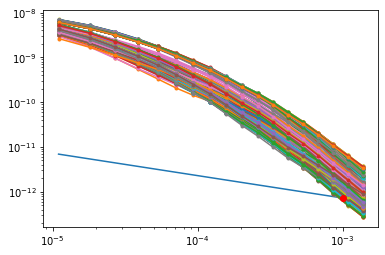

In [19]:
n_turns = 2
tx_currents = 6.04
t = 1e-3
v = 3e-9 / (area * n_turns * tx_currents)
c = v/(t**-0.5)
noise_lm = times_lm_312**-0.5 * c
plt.loglog(times_lm_312, times_lm_312**-0.5 * c)
out = plt.loglog(times_lm_312, -DOBS[::10,times_hm_312.size:].T, '.-')
plt.plot(t, v, 'ro')

In [20]:
noise_floor = np.hstack((np.tile(noise_hm, (n_sounding, 1)), np.tile(noise_lm, (n_sounding, 1)))) * np.random.randn(n_sounding, time.size)
floor = np.hstack((np.tile(noise_hm, (n_sounding, 1)), np.tile(noise_lm, (n_sounding, 1)))).flatten()
DOBS_noisy = DOBS + noise_floor

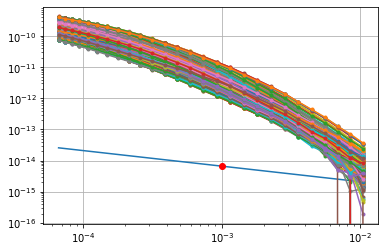

In [21]:
n_turns = 12
tx_currents = 110.10
t = 1e-3
v = 3e-9 / (area * n_turns * tx_currents)
c = v/(t**-0.5)
noise_hm = times_hm_312**-0.5 * c
plt.loglog(times_hm_312, times_hm_312**-0.5 * c)
out = plt.loglog(times_hm_312, -DOBS_noisy[::10,:times_hm_312.size].T, '.-')
# plt.plot(times_hm_312, np.ones_like(times_hm_312) * 1e-14, 'k--')
plt.plot(t, v, 'ro')
plt.grid(True)

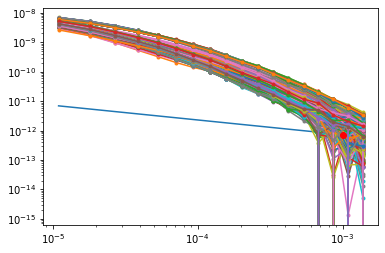

In [22]:
n_turns = 2
tx_currents = 6.04
t = 1e-3
v = 3e-9 / (area * n_turns * tx_currents)
c = v/(t**-0.5)
noise_lm = times_lm_312**-0.5 * c
plt.loglog(times_lm_312, times_lm_312**-0.5 * c)
out = plt.loglog(times_lm_312, -DOBS_noisy[::10,times_hm_312.size:].T, '.-')
plt.plot(t, v, 'ro')

In [23]:
std = 0.03
uncert = abs(dobs)*std + floor
survey.dobs = dobs

In [24]:
mesh = get_2d_mesh(n_sounding, hz)
m0 = np.ones(mesh.nC) * np.log(1./30.)
regmap = Maps.IdentityMap(mesh)
# mapping is required ... for IRLS
reg = LateralConstraint(
    mesh, mapping=regmap,
    alpha_s = 1.,
    alpha_x = 5.,
    alpha_y = 1.,    
)
reg.get_grad_horizontal(xy[:,:], hz, dim=3, use_cell_weights=True, minimum_distance=1000.)
np.random.seed(1)
dmisfit = DataMisfit.l2_DataMisfit(survey)
dmisfit.W = 1./uncert
opt = Optimization.InexactGaussNewton(maxIter=20, maxIterCG=20)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
beta = Directives.BetaSchedule(coolingFactor=2, coolingRate=1)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1.)
target = Directives.TargetMisfit(chifact=1.)
save_model = Directives.SaveOutputDictEveryIteration()
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest, save_model, target])
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.DataMisfit.l2_DataMisfit assigning default std of 5%
SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputDictEveryIteration will save your inversion progress as dictionary: '###-InversionModel-2019-10-22-11-27.npz'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.35e+00  1.04e+07  0.00e+00  1.04e+07    1.08e+05      0              
   1  1.68e+00  2.77e+06  6.57e+04  2.88e+06    6.76e+04      1              
   2  8.39e-01  5.68e+05  2.28e+05  7.59e+05    5.88e+04      0   Skip BFGS  
   3  4.19e-01  1.52e+05  2.32e+05  2.49

In [40]:
np.save("./doi/m2", mopt)

In [25]:
save_model.outDict.keys()

dict_keys([1, 2, 3, 4])

In [26]:
invProb.phi_d / 97875.0

0.761118850735191

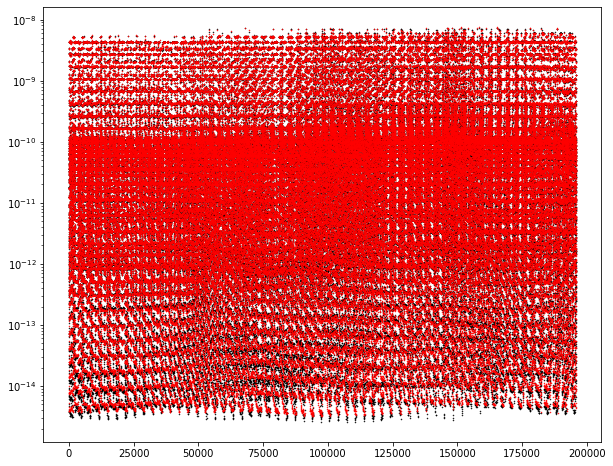

In [27]:
fig = plt.figure(figsize=(10, 8))
plt.semilogy(-dobs, 'k.', ms=1)
plt.semilogy(-invProb.dpred, 'r.', ms=1)

In [28]:
DOBS = dobs.reshape((n_sounding, times_hm_312.size+times_lm_312.size))
DPRED = invProb.dpred.reshape((n_sounding, times_hm_312.size+times_lm_312.size))

In [29]:
model = save_model.outDict

In [30]:
i_line = 14
# i_line = 40
ind_line = line == i_line
yc = np.unique(xy[ind_line,1])

In [31]:
yc

array([3934750.])

(716750.0, 753750.0)

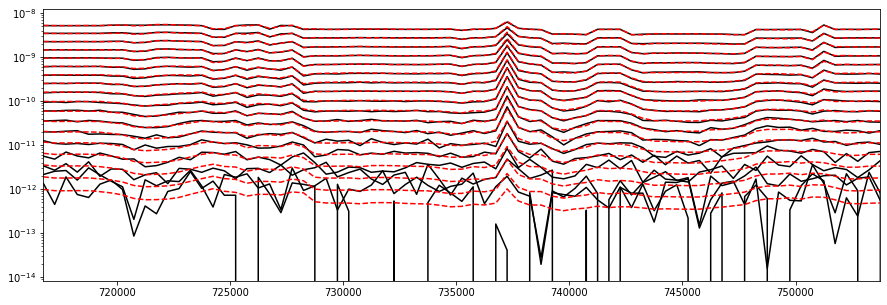

In [32]:
fig = plt.figure(figsize=(15, 5))
ind_line = line == 19
out = plt.semilogy(xy[ind_line, 0],-DOBS_noisy[ind_line,times_hm_312.size:], 'k')
out = plt.semilogy(xy[ind_line, 0],-DPRED[ind_line,times_hm_312.size:], 'r--')
plt.xlim(xy[:,0].min(), xy[:,0].max())

(716750.0, 753750.0)

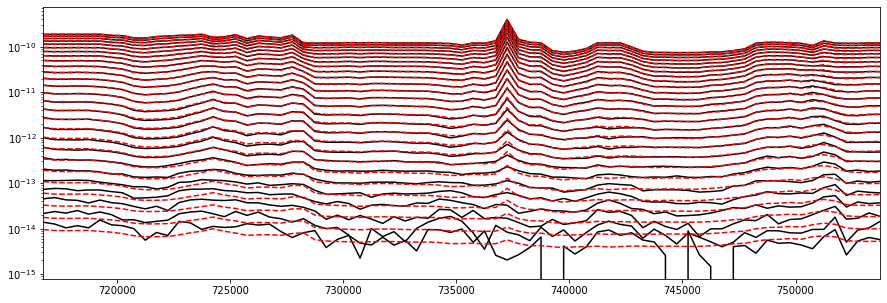

In [33]:
fig = plt.figure(figsize=(15, 5))
ind_line = line == 19
out = plt.semilogy(xy[ind_line, 0],-DOBS_noisy[ind_line,:times_hm_312.size], 'k')
out = plt.semilogy(xy[ind_line, 0],-DPRED[ind_line,:times_hm_312.size], 'r--')
plt.xlim(xy[:,0].min(), xy[:,0].max())

/home/sgkang09/.conda/envs/simpeg/lib/python3.7/site-packages/simpegEM1D-0.0.18a0-py3.7-linux-x86_64.egg/simpegEM1D/IO.py:55: UserWarning: code under construction - API might change in the future
  "code under construction - API might change in the future"


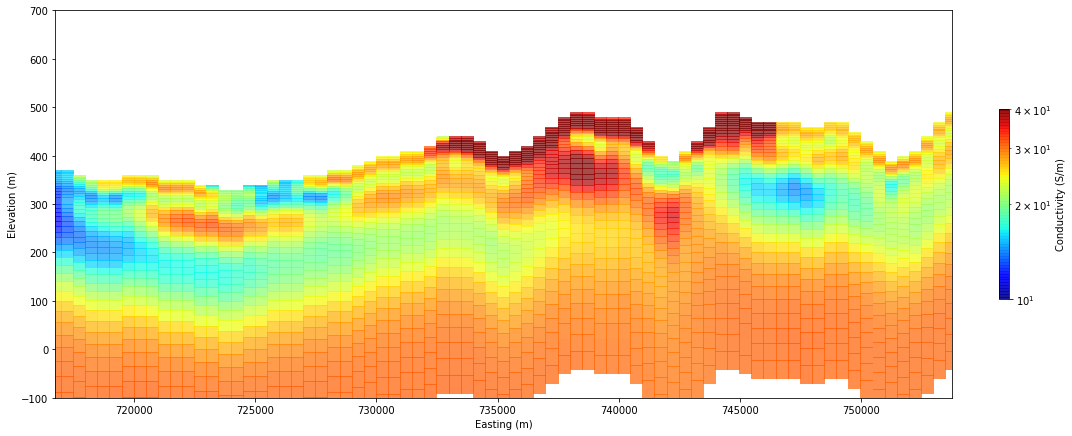

In [35]:
from simpegEM1D import ModelIO
nskip = 1
IO = ModelIO(
    hz=hz,
    topography=topo[::nskip,:], 
    physical_property=1./np.exp(Utils.mkvc(model[4]['m'].reshape((hz.size, n_sounding), order='F')[:,::nskip])),
    line=line[::nskip]
)

IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet', aspect=20, clim=(10, 40), dx=250, i_line=i_line)
plt.ylim(-100, 700)
plt.gca().set_aspect(20)

In [36]:
from scipy.interpolate import NearestNDInterpolator
f_int = NearestNDInterpolator(mesh_3d.gridCC, models['resistivity'])
xyz = IO.xyz.reshape((np.prod(IO.xyz.shape[:2]), IO.xyz.shape[2]))
tmp = f_int(xyz)
res_true= Utils.mkvc(tmp.reshape(IO.xyz.shape[:2]))

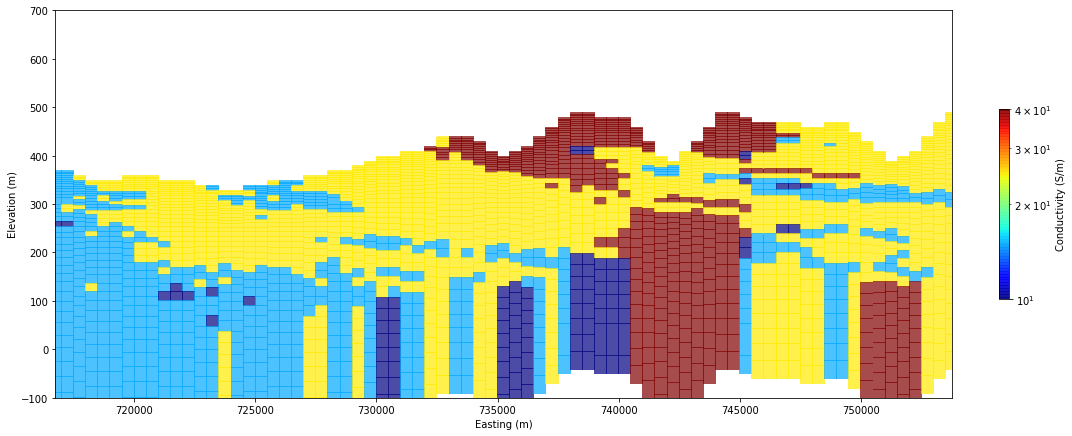

In [37]:
from simpegEM1D import ModelIO
nskip = 1
IO = ModelIO(
    hz=hz,
    topography=topo[::nskip,:], 
    physical_property=res_true,
    line=line[::nskip]
)
IO.plot_section(line_direction='x', scale='log', plot_type='pcolor', cmap='jet', aspect=20, clim=(10, 40), dx=250, i_line=i_line)
plt.ylim(-100, 700)
plt.gca().set_aspect(20)

In [66]:
# pred = survey.dpred(m0) 

In [ ]:
# plt.semilogy(dobs, 'k.', ms=1)
# plt.semilogy(-pred, 'r.', ms=1)